In [2]:
from torch.utils.data import DataLoader, random_split, TensorDataset
import torch
import numpy as np
from torchvision import transforms
import os
from pathlib import Path
# os.chdir("/kaggle/input/python-files/")
# from dataset import load_train_dataset, ImageMaskDataset
# os.chdir("/kaggle/input")
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from torchmetrics.classification import BinaryF1Score
import matplotlib.pyplot as plt
import random
import cv2


In [3]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
def set_seeds():
    torch.manual_seed(0xC0FFEE)
    np.random.seed(0xC0FFEE)
set_seeds()

In [6]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        """
        Custom dataset for loading images and masks.

        Args:
            image_dir (str): Directory containing images.
            mask_dir (str): Directory containing masks.
            transform (callable, optional): Transformations to apply to the images.
            mask_transform (callable, optional): Transformations to apply to the masks.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted(
            os.listdir(image_dir)
        )  # Sort to align images with masks
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load image and mask
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(image_path).convert("RGB")  # Convert image to RGB
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale

        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

In [7]:
image_dir = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/train/images"
mask_dir = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/train/masks"
IMG_SHAPE = (448, 448)

image_transform = transforms.Compose(
    [
        transforms.Resize(IMG_SHAPE),  # Ensure consistent size
        transforms.ToTensor(),
      
    ]
)

mask_transform = transforms.Compose(
    [
        transforms.Resize((448, 448)), 
        transforms.ToTensor(),  
        torch.round
        
    ]
)

dataset = ImageMaskDataset(
    image_dir, mask_dir, transform=image_transform, mask_transform=mask_transform
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


# Model

In [8]:
class Block(nn.Module):
    def __init__(self, in_channels: int, out_channel: int):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channel, kernel_size=3, padding="same", padding_mode="replicate"),
            nn.ReLU(),
            nn.BatchNorm2d(out_channel),
            
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding="same", padding_mode="replicate"),
            nn.ReLU(),
            nn.BatchNorm2d(out_channel),
        )

    def forward(self, X):
        return self.net(X)


class Encoder(nn.Module):
    def __init__(self, channels: tuple[int, ...]):
        super().__init__()
        assert channels[0] < channels[1]

        self.blocks = nn.ModuleList(
            [Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)]
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, X):
        downscaled_features = []
        for block in self.blocks:
            X = block(X)
            downscaled_features.append(X)
            X = self.pool(X)

        return downscaled_features


class Decoder(nn.Module):
    def __init__(self, channels: tuple[int, ...]):
        assert channels[0] > channels[1]

        super().__init__()

        self.blocks = nn.ModuleList(
            [Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)]
        )
        self.up_convolution = nn.ModuleList(
            [
                nn.ConvTranspose2d(
                    channels[i], channels[i + 1], kernel_size=2, stride=2
                )
                for i in range(len(channels) - 1)
            ]
        )

    def forward(self, X, downscaled_features):
        for i, block in enumerate(self.blocks):
            X = self.up_convolution[i](X)

            # Adding the previously downscaled feature
            feature = downscaled_features[i]
            _, _, h, w = X.shape
            X = torch.cat([X, feature], dim=1)

            X = block(X)

        return X


class UNet(nn.Module):
    def __init__(
        self, encoding_channels: tuple[int, ...], decoding_channels: tuple[int, ...], output_format=(448,448)
    ):
        super().__init__()
        self.encoder = Encoder(encoding_channels)
        self.decoder = Decoder(decoding_channels)
        self.head_out = nn.Conv2d(decoding_channels[-1], 1, kernel_size=1, padding="same", padding_mode="replicate")
        
        self.output_format = output_format

    def forward(self, X):
        features = self.encoder(X)
        X = self.decoder(features[-1], features[::-1][1:])
        X = self.head_out(X)
       
        return X


In [9]:
def predict(img, model):
    transformed_img = image_transform(img).to(device)
    transformed_img = transformed_img[None,:,:,:]
    model.eval()
    with torch.no_grad():
        logits = model(transformed_img)
        probs = torch.sigmoid(logits)

        mask = probs > 0.5

    return mask



# Trainer

In [10]:
def draw_random_predictions(model):
    num_of_images = 3
    img_files = [f for f in os.listdir(image_dir)]
    selected_files = random.sample(img_files, num_of_images)

    fig, axs = plt.subplots(3,3)
    
    for i, file_name in enumerate(selected_files):
        img_path = os.path.join(image_dir, file_name)
        mask_path = os.path.join(mask_dir, file_name)
        
        image = Image.open(img_path).convert("RGB") 
        
        mask = Image.open(mask_path).convert("L")
        mask = mask_transform(mask)
        
        prediction = predict(image, model)
        axs[i,0].imshow(image)
        
        axs[i,1].imshow(prediction[0,0].cpu(), cmap="gray")

        axs[i,2].imshow(mask[0], cmap="gray")

# a = Image.open("/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/train/images/CFD_002.jpg").convert("RGB")


In [11]:
class Trainer:
    def __init__(
        self,
        *,
        model,
        loss_function,
        train_loader,
        val_loader,
        optimizer,
    ):

        if (num_of_gpu := torch.cuda.device_count()) > 1:
            self.model = torch.nn.DataParallel(model, device_ids = [i for i in range(num_of_gpu)]).to(device)
        else:
            self.model = model.to(device)
            
        
        self.loss_function = loss_function
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        self.train_f1s = []
        self.val_f1s = []

    def train_one_epoch(self):
        self.model.train()
        running_loss = 0
        running_f1 = 0
        f1_score =  BinaryF1Score(multidim_average="samplewise")

        for X_batch, y_batch in self.train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            assert X_batch.shape[-2:] == y_batch.shape[-2:], f"{X_batch.shape[-2:]=} {y_batch.shape[-2:]=}"
            
            
            self.optimizer.zero_grad()
            
            y_batch_prediced = self.model(X_batch)
            assert y_batch_prediced.shape == y_batch.shape, f"{y_batch_prediced.shape=} {y_batch.shape=}"
            
            loss = self.loss_function(y_batch_prediced, y_batch)

            loss.backward()
            self.optimizer.step()

            crack_mask_predicted = torch.sigmoid(y_batch_prediced) > 0.5
            
            f1 = f1_score(crack_mask_predicted, y_batch).mean()
            
            running_loss += loss.item()
            running_f1 += f1.item()

        epoch_loss = running_loss / len(self.train_loader)
        epoch_f1 = running_f1 / (len(self.train_loader))
        
        return epoch_loss, epoch_f1

    def validate(self):
        self.model.eval()
        running_loss = 0
        running_f1 = 0
        f1_score =  BinaryF1Score(multidim_average="samplewise")
        with torch.no_grad():
            for X_batch, y_batch in self.val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                y_batch_prediced = self.model(X_batch)
                loss = self.loss_function(y_batch_prediced, y_batch)

                crack_mask_predicted = torch.sigmoid(y_batch_prediced) > 0.5
                f1 = f1_score(crack_mask_predicted, y_batch).mean()
                
                
                running_loss += loss.item()
                running_f1 += f1.item()
                

        epoch_loss = running_loss / len(self.val_loader)
        epoch_f1 =running_f1 / len(self.val_loader)

        return epoch_loss, epoch_f1

    def train(self, epochs: int, patience: int):
        best_f1 = -1
        no_improvement = 0
        for epoch in range(epochs):
            train_loss, train_f1 = self.train_one_epoch()
            val_loss, val_f1 = self.validate()

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_f1s.append(train_f1)
            self.val_f1s.append(val_f1)

          
            print("----------------------")
            print(f"Epoch: {epoch}: train loss: {train_loss}, validation loss: {val_loss}")
            print(f"                train Dice coeff (f1):{train_f1}, validation Dice coeff (f1): {val_f1}", end="")
            
            current_best_marker = ""
            if val_f1 > best_f1:
                no_improvement = 0
                best_f1 = val_f1
                torch.save(model.state_dict(), 'best_model.pth')
                current_best_marker ="<= New Best"
            else:
                no_improvement += 1
                if no_improvement == patience:
                    print(f"Stopped early! Epochs with no improvement: {no_improvement}, (patience: {patience})")
                    break
            print(current_best_marker)
            print()
            

    def plot(self):
        plt.subplot(2,1,1)
        plt.plot(self.train_losses, label="Train")
        plt.plot(self.val_losses, label="Validation")
        plt.title("Loss")
        plt.legend()

        plt.subplot(2,1,2)
        plt.plot(self.train_f1s, label="Train")
        plt.plot(self.val_f1s, label="Validation")
        plt.title("Dice coeffitient (F1)")
        plt.legend()
        
        plt.show()
        
endoding_channels = (3, 64, 128, 256, 512, 1024)
decoding_channels = (1024, 512, 256, 128, 64)
model = UNet(endoding_channels, decoding_channels)
trainer = Trainer(
    model=model,
    loss_function=torch.nn.BCEWithLogitsLoss(),
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=torch.optim.SGD(model.parameters(), lr=0.01)
)

----------------------
Epoch: 0: train loss: 0.27415439978815637, validation loss: 0.1432627950219198
                train Dice coeff (f1):0.14557114304513374, validation Dice coeff (f1): 0.12144162522820191<= New Best

----------------------
Epoch: 1: train loss: 0.11655272681820406, validation loss: 0.10686604754373245
                train Dice coeff (f1):0.19597853036669086, validation Dice coeff (f1): 0.17773466034168262<= New Best

----------------------
Epoch: 2: train loss: 0.09522966174147132, validation loss: 0.12210317178633204
                train Dice coeff (f1):0.2990861925278072, validation Dice coeff (f1): 0.34573605452583045<= New Best

----------------------
Epoch: 3: train loss: 0.08515905334956315, validation loss: 0.08349592918800615
                train Dice coeff (f1):0.35268869786741336, validation Dice coeff (f1): 0.3687416500879521<= New Best

----------------------
Epoch: 4: train loss: 0.07835689075407451, validation loss: 0.07719192857935221
            

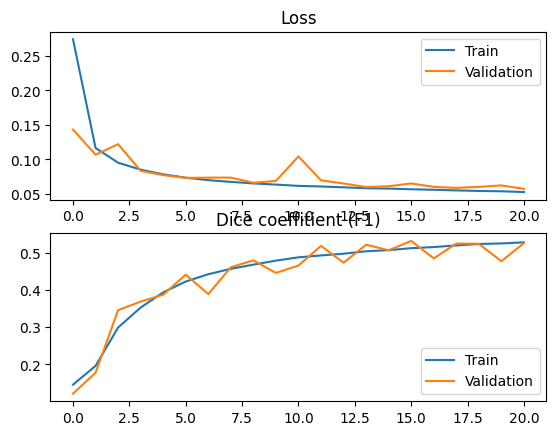

CPU times: user 3h 53min 25s, sys: 1h 45min 12s, total: 5h 38min 38s
Wall time: 5h 22min 12s


In [12]:
%%time
trainer.train(epochs=24, patience=5)
trainer.plot()


In [15]:
best_model = UNet(endoding_channels, decoding_channels)
best_model.load_state_dict(torch.load("best_model.pth", weights_only=True))
best_model = best_model.to(device)
trainer = Trainer(
    model=model,
    loss_function=torch.nn.BCEWithLogitsLoss(),
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=torch.optim.SGD(model.parameters(), lr=0.001)
)

----------------------
Epoch: 0: train loss: 0.05051307390278262, validation loss: 0.05583054049875726
                train Dice coeff (f1):0.5403327746055129, validation Dice coeff (f1): 0.5377100555233936<= New Best

----------------------
Epoch: 1: train loss: 0.049931719534789115, validation loss: 0.057578730037536364
                train Dice coeff (f1):0.5435471887022846, validation Dice coeff (f1): 0.53510928642453

----------------------
Epoch: 2: train loss: 0.049911263519965894, validation loss: 0.05593910928490993
                train Dice coeff (f1):0.5440499008508181, validation Dice coeff (f1): 0.5276648572248047

----------------------
Epoch: 3: train loss: 0.04987233147629838, validation loss: 0.05757311659698912
                train Dice coeff (f1):0.5436936280574809, validation Dice coeff (f1): 0.5403608428121107<= New Best

----------------------
Epoch: 4: train loss: 0.049684552908036764, validation loss: 0.05582321630752186
                train Dice coeff (f1)

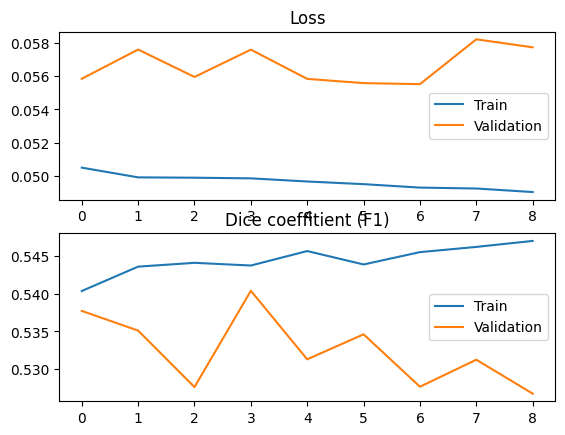

CPU times: user 1h 39min 41s, sys: 44min 56s, total: 2h 24min 38s
Wall time: 2h 17min 22s


In [16]:
%%time
trainer.train(epochs=24, patience=5)
trainer.plot()


In [14]:
os.listdir("/kaggle/working")

['.virtual_documents', 'best_model.pth', 'state.db']